In [1]:
from DataUtils import DataInterface
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d;

%matplotlib inline

In [3]:
def stateUpdate(state):
    return state

In [16]:
class GaussianParticleFilter:
    def __init__(self, systemCov, measCov, stateUpdate, measMatrix, initialMeas, n_particles=100, resample_thresh=20):
        '''
            systemCov = State Update Covariance Matrix
            measCov = Measurement Covariance Matrix (Sensor Covariances)
            stateUpdate = python function that takes in previous state and predicts next state
            measMatrix = matrix that converts state vector to measurement vector
            initialState = starting off state
        '''
        #init covariances
        self.Q = systemCov
        self.Q_inv = np.linalg.inv(self.Q)
        self.R = measCov
        self.R_inv = np.linalg.inv(self.R)
        
        #measurements
        self.C = measMatrix
        self.initialMeas = initialMeas
        self.n_particles = n_particles
        
        #init stateUpdates
        self.stateUpdate = stateUpdate
        
        #init paricles
        self.particles = np.zeros(shape=(n_particles,systemCov.shape[0]), dtype=np.float32)
        self.weights = np.zeros(shape=(n_particles,),dtype=np.float32)
        
        self.resample_thresh = resample_thresh
        for i in range(n_particles):
            self.particles[i] = self.initialMeas.flatten()
            self.weights[i] = 1/n_particles
        self.ESS = 1 / np.sum( self.weights**2 )
        
        
        self.sig0 = np.linalg.inv(self.Q_inv + self.C.T @ self.R_inv @ self.C)
    def convert_meas_to_state(self, meas):
        return np.linalg.inv(self.C)@meas
    def predict(self, meas):
        y_t = meas
        particles1 = np.zeros(self.particles.shape,dtype=np.float32)
        weights1 = np.zeros((self.n_particles,), dtype=np.float32)
        
        w_sum = 0
        for i in range(self.n_particles):
            f_x1 = self.stateUpdate(self.particles[i,:].reshape(8,1))
            mu = self.sig0 @ (self.Q_inv@f_x1 + self.C.T @ self.R_inv @ y_t)
            particles1[i,:] = np.random.multivariate_normal(mu.flatten(),self.sig0)

            weights1[i] = ((y_t - self.C@f_x1).T @ np.linalg.inv(self.sig0) @ (y_t - self.C@f_x1))[0,0]
            w_sum += weights1[i]
        weights1 /= w_sum
        self.particles = particles1
        self.weights = weights1
        
        self.ESS = 1 / np.sum( self.weights**2 )
        
        if self.ESS < self.resample_thresh:
            self.resample()

    def estimate(self):
        return np.sum( self.particles * self.weights.reshape(self.n_particles,1), axis=0)
    def resample(self):
        choices = np.random.choice( np.arange(self.n_particles), self.n_particles, p=self.weights)
        particles_new = self.particles[choices,:]
        weights_new = 1/self.n_particles + np.zeros(self.weights.shape,dtype=np.float32)
        
        self.particles = particles_new
        self.weights = weights_new
        
        self.ESS = 1 / np.sum( self.weights**2 )

In [17]:
class SensorReader:
    def __init__(self, radiusOfEarth, encoder_resolution, encoder_diameterL, encoder_diameterR):
        self.data_interface = DataInterface(
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/gps.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/xsens_imu.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/encoder.csv"
        )
        # data -> (lon,lat,alt,left,right,yaw,pitch,roll)
        self.R = radiusOfEarth
        self.res = encoder_resolution
        self.angle_to_rad = np.pi/180
        self.enc_radL = encoder_diameterL / 2
        self.enc_radR = encoder_diameterR / 2
        
        self.init_data = self.parse(self.data_interface.read())
        self.meas = self.init_data.copy()
        self.meas[0:5] = 0 #re-init
        
    def parse(self, data):
        gps = data['gps_data']
        imu = data['imu_data']
        enc = data['encoders_data']
        lat,lon,alt = gps[1:4]
        pitch, roll, yaw = imu[5:8]
        left,right = enc[1:3]
        
        lat = lat*np.pi/180*self.R
        lon = lon*np.pi/180*self.R
        left = left * 2*np.pi/self.res * self.enc_radL
        right = right * 2*np.pi/self.res * self.enc_radR
        
        #pitch = pitch * np.pi / 180
        #yaw = yaw * np.pi / 180
        #roll = roll * np.pi / 180
        
        return np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
    def read(self):
        self.meas = self.parse(self.data_interface.read())
        self.meas[0:5] -= self.init_data[0:5]
        return self.meas

In [18]:
R = 6_371_000 #earth's radius in meters
encDiamL = 0.623022
encDiamR = 0.622356
res = 4096
wheelbase = 1.5285

sensors = SensorReader(R, res, encDiamL, encDiamR)

In [19]:
data = np.array([[0,0,0,0,0,0,0,0]]).T
for i in range(1_000):
    data = np.hstack((data,sensors.read()))

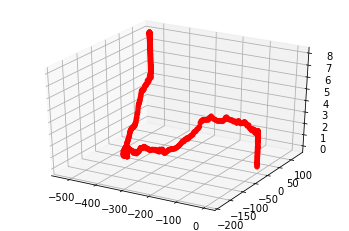

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data[0,:], data[1,:], data[2,:], c='red')
plt.show()

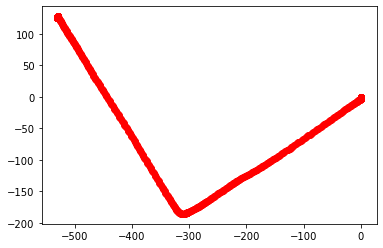

In [21]:
plt.scatter(data[0,:], data[1,:],c='red')
plt.show()

In [35]:
R = 6_371_000 #earth's radius in meters
encDiamL = 0.623022
encDiamR = 0.622356
res = 4096
baseline = 1.5285

sensors = SensorReader(R, res, encDiamL, encDiamR)

In [36]:
C = np.zeros(shape=(8,8), dtype=np.float32)
#longitude
C[0,0] = 1
#latitude
C[1,1] = 1
#altitude
C[2,2] = 1

#left encoder
C[3,3] = 1
C[3,4] = -baseline/2

#right encoder
C[4,3] = 1
C[4,4] = baseline/2

#yaw, pitch, roll
C[5,5] = 1
C[6,6] = 1
C[7,7] = 1

In [37]:
systemCov = np.eye(8)*3
measCov = np.eye(8)*1
#measCov[0:3,0:3] = gps_cov

In [38]:
pf = GaussianParticleFilter(systemCov,measCov, stateUpdate, C, sensors.read() )

In [39]:
data = pf.estimate().reshape(8,1)
data_GT = np.array([[0,0,0]]).T
for i in range(5_000):
    reading = sensors.read()
    data_GT = np.hstack((data_GT, reading))
    pf.predict(reading)
    data = np.hstack((data,pf.estimate().reshape(8,1)))

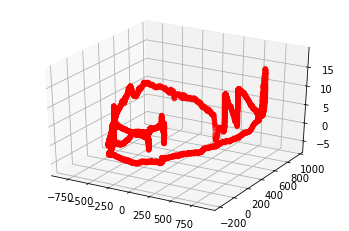

In [40]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0,:], data[1,:], data[2,:], c='red')
plt.show()

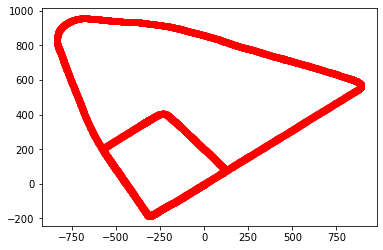

In [41]:
plt.scatter(data[0,:], data[1,:],c='red')
plt.show()